# Öğrencilerde Sosyal Medya Bağımlılığı Analizi ve Tahminlemesi

## 1. Proje Amacı
Bu projenin temel amacı, öğrencilerin demografik özellikleri, sosyal medya kullanım alışkanlıkları ve ruh halleri gibi verileri kullanarak **Sosyal Medya Bağımlılık Skorunu (Addicted_Score)** tahmin eden bir makine öğrenmesi modeli geliştirmektir.

Ayrıca şu sorulara cevap arayacağız:
* Günlük kullanım süresi ile bağımlılık arasında nasıl bir ilişki var?
* Hangi platformlar (TikTok, Instagram vb.) daha fazla bağımlılık yaratıyor?
* Sosyal medya kullanımı akademik başarıyı nasıl etkiliyor?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import joblib
import scipy.stats as stats  
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost as xgb 
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import shap
from warnings import filterwarnings
filterwarnings('ignore') 

In [2]:
df=pd.read_csv("Students Social Media Addiction.csv")

In [3]:
df.head()

,Student_ID,Age,Gender,Academic_Level,Country,Avg_Daily_Usage_Hours,Most_Used_Platform,Affects_Academic_Performance,Sleep_Hours_Per_Night,Mental_Health_Score,Relationship_Status,Conflicts_Over_Social_Media,Addicted_Score
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,Yes,6.5,6,In Relationship,3,8
1,2,22,Male,Graduate,India,2.1,Twitter,No,7.5,8,Single,0,3
2,3,20,Female,Undergraduate,USA,6.0,TikTok,Yes,5.0,5,Complicated,4,9
3,4,18,Male,High School,UK,3.0,YouTube,No,7.0,7,Single,1,4
4,5,21,Male,Graduate,Canada,4.5,Facebook,Yes,6.0,6,In Relationship,2,7


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Student_ID                    705 non-null    int64  
 1   Age                           705 non-null    int64  
 2   Gender                        705 non-null    object 
 3   Academic_Level                705 non-null    object 
 4   Country                       705 non-null    object 
 5   Avg_Daily_Usage_Hours         705 non-null    float64
 6   Most_Used_Platform            705 non-null    object 
 7   Affects_Academic_Performance  705 non-null    object 
 8   Sleep_Hours_Per_Night         705 non-null    float64
 9   Mental_Health_Score           705 non-null    int64  
 10  Relationship_Status           705 non-null    object 
 11  Conflicts_Over_Social_Media   705 non-null    int64  
 12  Addicted_Score                705 non-null    int64  
dtypes: fl

## 2. Veri Seti Tanımı
Veri setimiz 705 öğrenciye ait anket verilerini içermektedir. Önemli sütunlar şunlardır:
* **Avg_Daily_Usage_Hours:** Günlük ortalama sosyal medya kullanım saati.
* **Most_Used_Platform:** En sık kullanılan uygulama.
* **Mental_Health_Score:** Öğrencinin ruh sağlığı puanı (Yüksek puan iyi durumu gösterir).
* **Addicted_Score (Hedef Değişken):** Tahmin etmeye çalışacağımız bağımlılık skoru.

In [5]:
df = df.drop(['Student_ID'], axis=1)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,705.0,20.659574,1.399217,18.0,19.0,21.0,22.0,24.0
Avg_Daily_Usage_Hours,705.0,4.918723,1.257395,1.5,4.1,4.8,5.8,8.5
Sleep_Hours_Per_Night,705.0,6.868936,1.126848,3.8,6.0,6.9,7.7,9.6
Mental_Health_Score,705.0,6.226950,1.105055,4.0,5.0,6.0,7.0,9.0
Conflicts_Over_Social_Media,705.0,2.849645,0.957968,0.0,2.0,3.0,4.0,5.0
Addicted_Score,705.0,6.436879,1.587165,2.0,5.0,7.0,8.0,9.0


In [7]:
for i in df.select_dtypes(include='object').columns:
    print(df[i].value_counts())
    print('****'*20)

Gender
Female    353
Male      352
Name: count, dtype: int64
********************************************************************************
Academic_Level
Undergraduate    353
Graduate         325
High School       27
Name: count, dtype: int64
********************************************************************************
Country
India        53
USA          40
Canada       34
Denmark      27
Ireland      27
             ..
Uruguay       1
Ecuador       1
Venezuela     1
Peru          1
Jamaica       1
Name: count, Length: 110, dtype: int64
********************************************************************************
Most_Used_Platform
Instagram    249
TikTok       154
Facebook     123
WhatsApp      54
Twitter       30
LinkedIn      21
WeChat        15
Snapchat      13
LINE          12
KakaoTalk     12
VKontakte     12
YouTube       10
Name: count, dtype: int64
********************************************************************************
Affects_Academic_Performance
Yes    453

## 3. Özellik Mühendisliği (Feature Engineering)

In [8]:
#Uyanık kalınan sürenin ne kadarı ekranda geçiyor?
df['Awake_Usage_Rate'] = df['Avg_Daily_Usage_Hours'] / (24 - df['Sleep_Hours_Per_Night'])

# Birim kullanım saati başına düşen kavga sayısı (Eğer kullanım 0 ise hata vermesin diye 0.01 ekledik)
df['Conflict_Per_Hour'] = df['Conflicts_Over_Social_Media'] / (df['Avg_Daily_Usage_Hours'] + 0.01)

## 4. Keşifçi Veri Analizi (EDA)

Sayısal değişkenlerin dağılımını ve uç değerleri (outliers) incelemek için Boxplot grafikleri kullanıyoruz.
* **Gözlem:** Aşağıdaki grafiklerde, özellikle *Avg_Daily_Usage_Hours* değişkeninde bazı öğrencilerin ortalamanın çok üzerinde kullanım yaptığını görebiliriz.
* **İlişki Analizi:** *Mental_Health_Score* ile *Addicted_Score* arasında ters bir korelasyon olması beklenebilir.

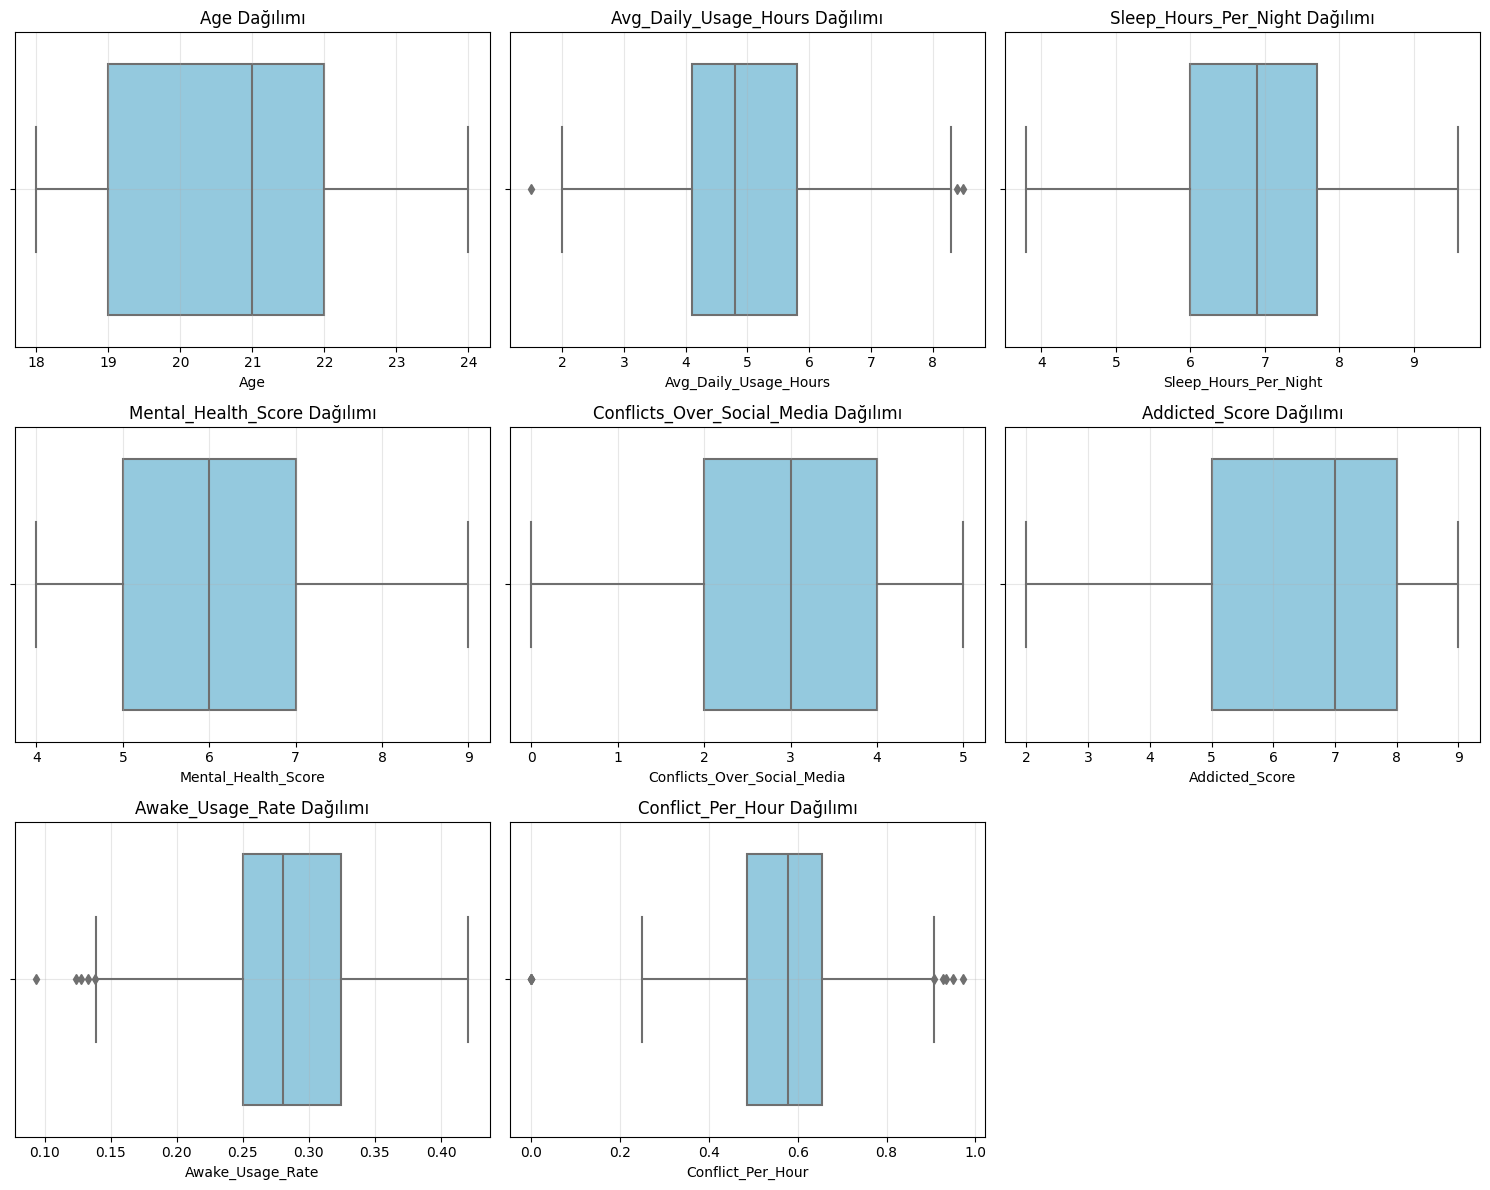

In [9]:
numeric_cols = df.select_dtypes(include=['number']).columns

num_plots = len(numeric_cols)
cols = 3  
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(15, rows * 4)) 

for i, column in enumerate(numeric_cols):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(x=df[column], color='skyblue') 
    plt.title(f'{column} Dağılımı')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

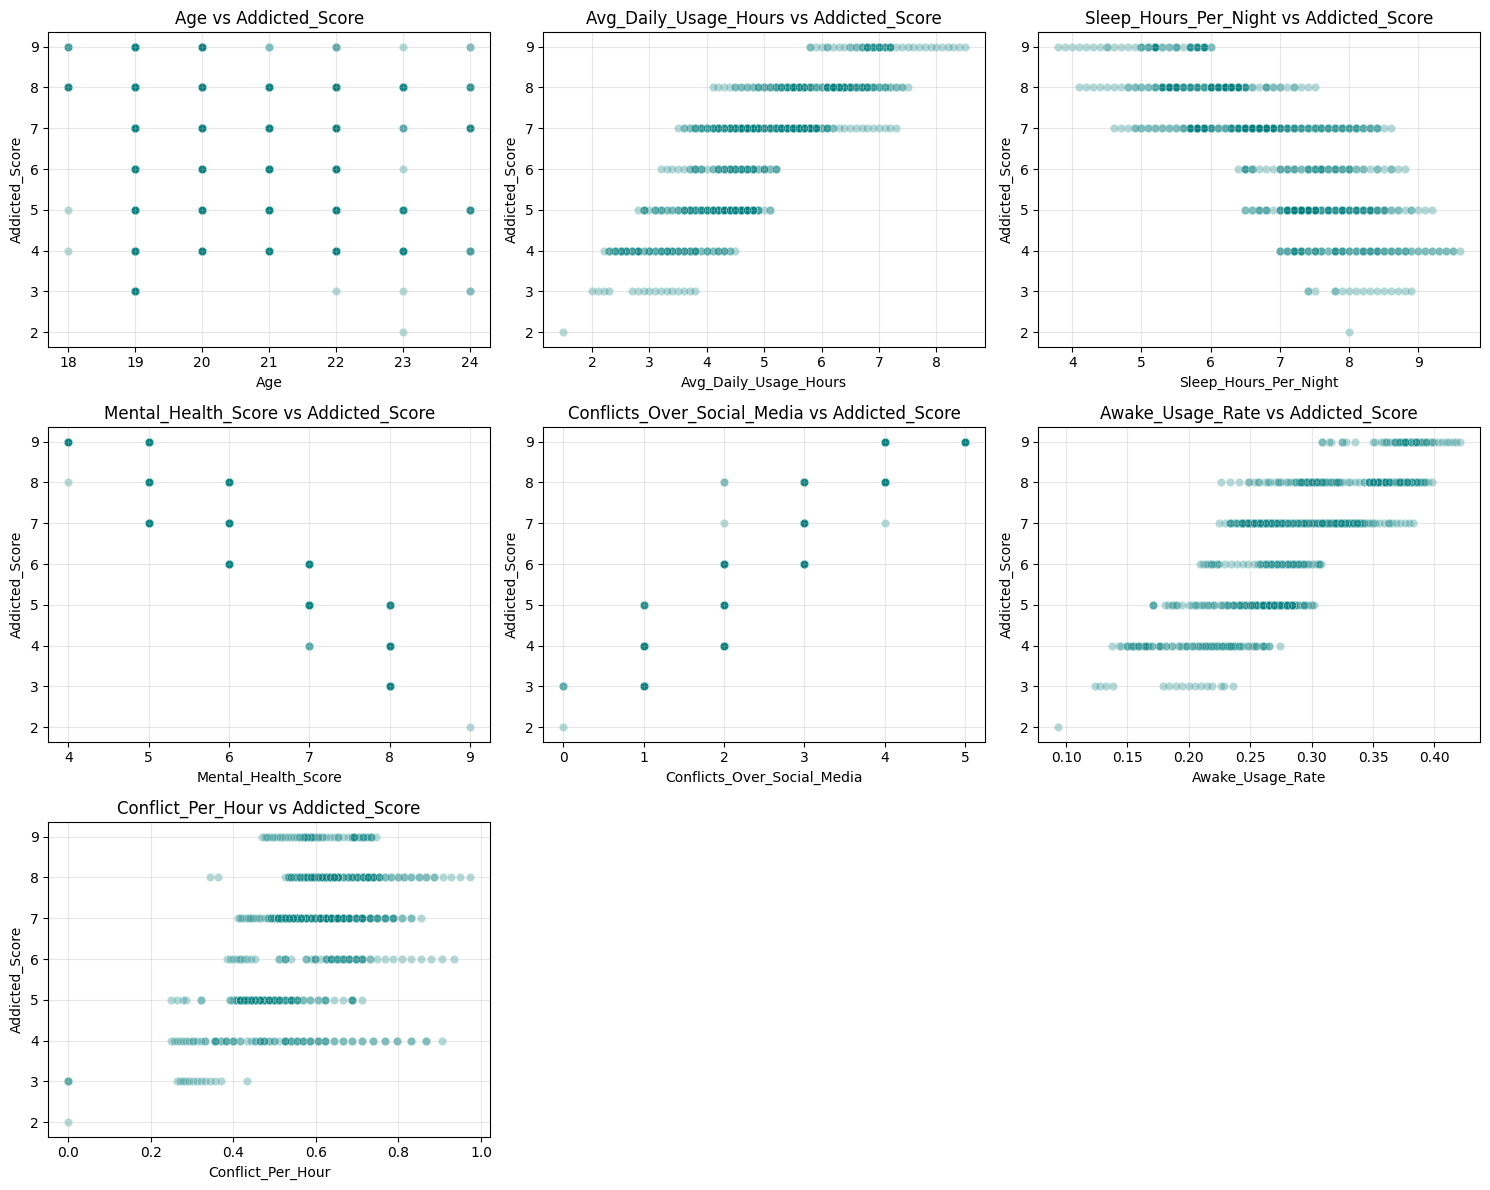

In [10]:
target_col = 'Addicted_Score'

numeric_cols = df.select_dtypes(include=['number']).columns
feature_cols = [col for col in numeric_cols if col != target_col]

num_plots = len(feature_cols)
cols = 3 
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(15, rows * 4))

for i, col in enumerate(feature_cols):
    plt.subplot(rows, cols, i + 1)
    
    sns.scatterplot(x=df[col], y=df[target_col], alpha=0.3, color='teal')
    
    plt.title(f'{col} vs {target_col}')
    plt.xlabel(col)
    plt.ylabel(target_col)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

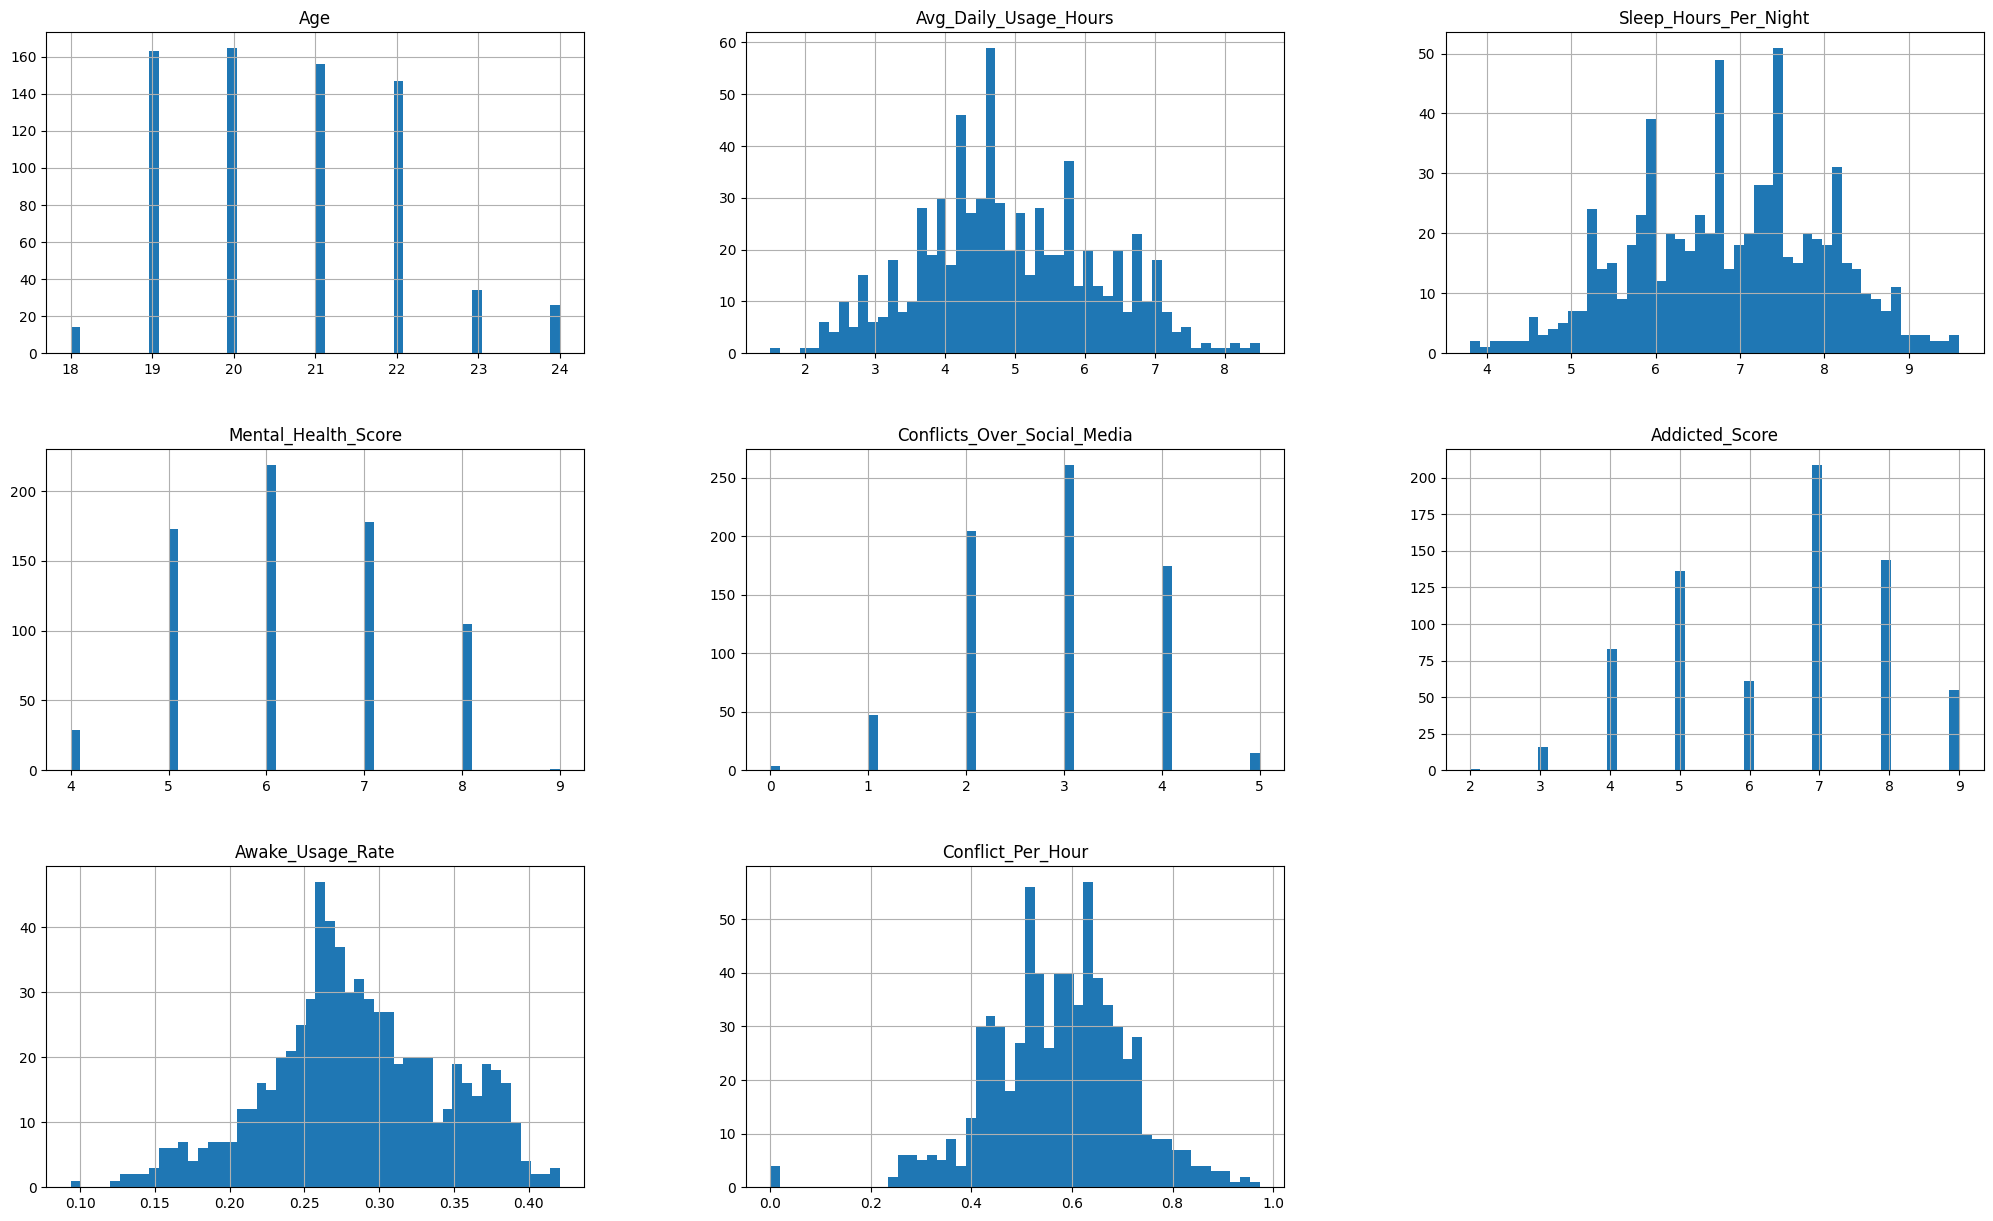

In [11]:
df.hist(bins=50,figsize=(25,15))
plt.show()

In [12]:
bool_cols = df.select_dtypes(include=['bool', 'int32']).columns
target_col = 'Addicted_Score'

num_plots = len(bool_cols)
cols = 3 
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(18, rows * 4))

for i, col in enumerate(bool_cols):
    plt.subplot(rows, cols, i + 1)
    
    sns.barplot(x=df[col], y=df[target_col], palette="viridis", errorbar=None) 
    
    means = df.groupby(col)[target_col].mean()
    for val, mean_val in means.items():
        plt.text(val, mean_val, f'{mean_val:.2f}', ha='center', va='bottom', fontweight='bold')

    plt.title(f'{col} Etkisi')
    plt.ylabel('Ortalama Bağımlılık Skoru')
    plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

<Figure size 1800x0 with 0 Axes>

## 5. Veri Ön İşleme (Feature Engineering)

Makine öğrenmesi modelleri metin (string) verilerle çalışamaz, sadece sayıları anlar. Bu nedenle:
1.  **Gereksiz Sütunlar:** Tahmin gücü olmayan `Student_ID` sütununu siliyoruz.
2.  **Kategorik Dönüşüm:** `Gender`, `Country`, `Platform` gibi metin verilerini **One-Hot Encoding** (get_dummies) yöntemiyle 0 ve 1'lere dönüştürüyoruz.
3.  **Ülke Gruplama:** Çok fazla ülke olduğu için, veri setinde az geçen ülkeleri "Other" (Diğer) olarak gruplayıp modelin kafasının karışmasını önlüyoruz.

In [13]:
df = pd.get_dummies(df, columns=['Gender'])

In [14]:
df=df.drop(["Gender_Male"],axis=1)

In [15]:
academic_order = {
    'High School': 0,    # En düşük seviye
    'Undergraduate': 1,  # Orta seviye
    'Graduate': 2        # En yüksek seviye
}

df['Academic_Level_encoded'] = df['Academic_Level'].map(academic_order)

df = df.drop(['Academic_Level'], axis=1)

print(df['Academic_Level_encoded'].value_counts())

Academic_Level_encoded
1    353
2    325
0     27
Name: count, dtype: int64


In [16]:
df = pd.get_dummies(df, columns=['Affects_Academic_Performance'])

In [17]:
df=df.drop(["Affects_Academic_Performance_Yes"],axis=1)

In [18]:
df = pd.get_dummies(df, columns=['Relationship_Status'])

In [19]:
df=df.drop(["Relationship_Status_Complicated"],axis=1)

In [20]:
df=df.drop(["Relationship_Status_In Relationship"],axis=1)

In [21]:
df = pd.get_dummies(df, columns=['Most_Used_Platform'])

In [22]:
top_10_countries = df['Country'].value_counts().head(10).index

df['Country'] = df['Country'].apply(lambda x: x if x in top_10_countries else 'Other')

df = pd.get_dummies(df, columns=['Country'], drop_first=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              705 non-null    int64  
 1   Avg_Daily_Usage_Hours            705 non-null    float64
 2   Sleep_Hours_Per_Night            705 non-null    float64
 3   Mental_Health_Score              705 non-null    int64  
 4   Conflicts_Over_Social_Media      705 non-null    int64  
 5   Addicted_Score                   705 non-null    int64  
 6   Awake_Usage_Rate                 705 non-null    float64
 7   Conflict_Per_Hour                705 non-null    float64
 8   Gender_Female                    705 non-null    bool   
 9   Academic_Level_encoded           705 non-null    int64  
 10  Affects_Academic_Performance_No  705 non-null    bool   
 11  Relationship_Status_Single       705 non-null    bool   
 12  Most_Used_Platform_Fac

## 6. Modelleme ve Sonuçlar

Verimizi eğitim (%80) ve test (%20) olarak ayırıp **Lineer Regresyon** modelini eğitiyoruz. Başarı kriteri olarak R2 Score (Açıklayıcılık Oranı) ve RMSE (Hata Kareler Ortalaması) kullanacağız.

In [24]:
X = df.drop("Addicted_Score", axis = 1)
y = df["Addicted_Score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 42)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              705 non-null    int64  
 1   Avg_Daily_Usage_Hours            705 non-null    float64
 2   Sleep_Hours_Per_Night            705 non-null    float64
 3   Mental_Health_Score              705 non-null    int64  
 4   Conflicts_Over_Social_Media      705 non-null    int64  
 5   Addicted_Score                   705 non-null    int64  
 6   Awake_Usage_Rate                 705 non-null    float64
 7   Conflict_Per_Hour                705 non-null    float64
 8   Gender_Female                    705 non-null    bool   
 9   Academic_Level_encoded           705 non-null    int64  
 10  Affects_Academic_Performance_No  705 non-null    bool   
 11  Relationship_Status_Single       705 non-null    bool   
 12  Most_Used_Platform_Fac

In [26]:
X_train = X_train.astype(float)
y_train = y_train.astype(float)

In [27]:
lm = sm.OLS(y_train, X_train)

In [28]:
model = lm.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Addicted_Score   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     589.8
Date:                Mon, 09 Feb 2026   Prob (F-statistic):               0.00
Time:                        12:06:50   Log-Likelihood:                -45.832
No. Observations:                 564   AIC:                             157.7
Df Residuals:                     531   BIC:                             300.7
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Age                                -0.0297      0.017     -1.779      0.076      -0.062       0.003
Avg_Daily_Usage_Hours              -0.0416      0.217     -0.192      0.848      -0.467       0.384
Sleep_Hours_Per_Night              -0.2260      0.064     -3.516      0.000      -0.352      -0.100
Mental_Health_Score                -0.5481      0.030    -18.476      0.000      -0.606      -0.490
Conflicts_Over_Social_Media         0.1212      0.095      1.273      0.204      -0.066       0.308
Awake_Usage_Rate                    5.3074      3.854      1.377      0.169      -2.263      12.878
Conflict_Per_Hour                   1.4686      0.403      3.642      0.000       0.677       2.261
Gender_Female                      -0.0178      0.033     -0.532      0.595      -0.083       0.048
Academic_Level_encoded              0.0270      0.046      0.585      0.559      -0.064       0.118
Affects_Academic_Performance_No    -0.5951      0.068     -8.800      0.000      -0.728      -0.462
Relationship_Status_Single         -0.0883      0.030     -2.906      0.004      -0.148      -0.029
Most_Used_Platform_Facebook         9.8753      0.589     16.773      0.000       8.719      11.032
Most_Used_Platform_Instagram        9.8523      0.585     16.832      0.000       8.702      11.002
Most_Used_Platform_KakaoTalk        9.0530      0.599     15.106      0.000       7.876      10.230
Most_Used_Platform_LINE             9.0944      0.596     15.260      0.000       7.924      10.265
Most_Used_Platform_LinkedIn         9.9296      0.592     16.767      0.000       8.766      11.093
Most_Used_Platform_Snapchat        10.1456      0.596     17.029      0.000       8.975      11.316
Most_Used_Platform_TikTok           9.9895      0.586     17.057      0.000       8.839      11.140
Most_Used_Platform_Twitter          9.7158      0.592     16.425      0.000       8.554      10.878
Most_Used_Platform_VKontakte        9.8217      0.599     16.406      0.000       8.646      10.998
Most_Used_Platform_WeChat           9.8750      0.602     16.395      0.000       8.692      11.058
Most_Used_Platform_WhatsApp         9.6316      0.601     16.036      0.000       8.452      10.811
Most_Used_Platform_YouTube         10.2691      0.588     17.468      0.000       9.114      11.424
Country_Denmark                    -0.4004      0.094     -4.241      0.000      -0.586      -0.215
Country_France                     -0.1738      0.095     -1.839      0.066      -0.359       0.012
Country_India                       0.0407      0.085      0.477      0.634      -0.127       0.208
Country_Ireland                    -0.1141      0.081     -1.406      0.160      -0.273       0.045
Country_Mexico                     -0.0314      0.089     -0.351      0.726      -0

In [29]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [30]:
rmse = np.sqrt(mean_squared_error(y_train, lr_model.predict(X_train)))

In [31]:
rmse

0.2624548721361395

In [32]:
lr_model.score(X_train, y_train)

0.9726371848319434

In [33]:
xgb_model = XGBRegressor().fit(X_train, y_train)

In [34]:
y_pred = xgb_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

0.18291262835264346

In [35]:
r2_score(y_test, y_pred)

0.9866294264793396

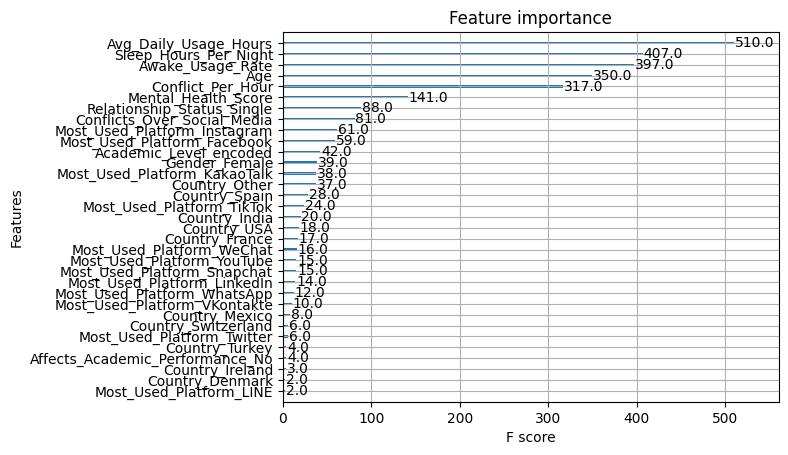

In [36]:
plot_importance(xgb_model)
plt.show()

In [37]:
xgb_model

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [38]:
xgb_grid = {
    'n_estimators': [100, 500, 1000],  
    'learning_rate': [0.01, 0.05, 0.1], 
    'max_depth': [3, 5, 7],            
    'min_child_weight': [1, 3],        
    'gamma': [0, 0.1],                 
    'subsample': [0.8],                
    'colsample_bytree': [0.8]          
}

In [39]:
xgb = XGBRegressor()

xgb_cv = GridSearchCV(xgb, 
                      param_grid = xgb_grid, 
                      cv = 10, 
                      n_jobs = -1,
                      verbose = 2)


xgb_cv.fit(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


,estimator,"XGBRegressor(...ate=None, ...)"
,param_grid,"{'colsample_bytree': [0.8], 'gamma': [0, 0.1], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], ...}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,10
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [40]:
xgb_cv.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 100,
 'subsample': 0.8}

In [41]:
xgb_tuned = XGBRegressor(colsample_bytree =0.8 ,
                         gamma =0,
                         learning_rate = 0.05, 
                         max_depth = 7, 
                         n_estimators =100,
                         min_child_weight = 3,
                         subsample = 0.8) 

xgb_tuned = xgb_tuned.fit(X_train,y_train)

In [42]:
y_pred = xgb_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

0.19152528603595526

In [43]:
r2_score(y_test, y_pred)

0.9853406548500061

## 7. Model Performanslarının İstatistiksel Karşılaştırması (A/B Testi)

Modellerin başarı metriklerine (RMSE, R2) bakarak birinin diğerinden "daha iyi" olduğunu söylemek bazen yanıltıcı olabilir. Aradaki farkın **şans eseri** mi yoksa **istatistiksel olarak anlamlı** mı olduğunu test etmek için bir Hipotez Testi (A/B Testi) uyguluyoruz.

* **H0 (Boş Hipotez):** XGBoost ve Linear Regression modellerinin tahmin hataları arasında anlamlı bir fark yoktur.
* **H1 (Alternatif Hipotez):** İki modelin başarısı arasında istatistiksel olarak anlamlı bir fark vardır.

**Yöntem:**
1.  Önce hataların farkının normal dağılıp dağılmadığını **Shapiro-Wilk Testi** ile kontrol ediyoruz.
2.  Normal dağılıyorsa **Bağımlı T-Testi**, dağılmıyorsa **Wilcoxon Signed-Rank Testi** (parametrik olmayan) kullanarak karar veriyoruz.

In [44]:
hatalar_xgb = np.abs(y_test - y_pred)
hatalar_lr = np.abs(y_test - y_pred_lr)

print(f"XGBoost Ortalama Hata: {np.mean(hatalar_xgb):.2f}")
print(f"Lineer  Ortalama Hata: {np.mean(hatalar_lr):.2f}")

XGBoost Ortalama Hata: 0.09
Lineer  Ortalama Hata: 0.21


In [45]:
import scipy.stats as stats
test_stat, p_shapiro = stats.shapiro(hatalar_xgb - hatalar_lr)
print(f"Normallik Testi P-value: {p_shapiro:.5f}")

# H0: İki modelin başarısı arasında fark YOKTUR.
# H1: İki model arasında fark VARDIR.

if p_shapiro > 0.05:
    # Veriler Normal Dağılıyorsa Bağımlı T-Testi 
    print("Test: Bağımlı T-Testi (Parametrik)")
    test_istatistigi, p_value = stats.ttest_rel(hatalar_xgb, hatalar_lr)
else:
    # Veriler Normal DEĞİLSE Wilcoxon Testi [cite: 584]
    print("Test: Wilcoxon Signed-Rank Testi (Non-Parametrik)")
    test_istatistigi, p_value = stats.wilcoxon(hatalar_xgb, hatalar_lr)

print(f"\n--- SONUÇ ---")
print(f"P-Value Değeri: {p_value}")

if p_value < 0.05:
    print("KARAR: H0 Reddedildi")
    if np.mean(hatalar_xgb) < np.mean(hatalar_lr):
        print("Yorum: XGBoost, Lineer modelden İSTATİSTİKSEL OLARAK anlamlı derecede daha iyi.")
    else:
        print("Yorum: Fark var ama XGBoost daha kötü çıktı.")
else:
    print("KARAR: H0 Reddedilemedi.")
    print("Yorum: Rakamlar farklı görünse de, bu fark şans eseri olabilir. XGBoost'un kesin bir üstünlüğü kanıtlanamadı.")

Normallik Testi P-value: 0.00000
Test: Wilcoxon Signed-Rank Testi (Non-Parametrik)

--- SONUÇ ---
P-Value Değeri: 4.658467494120852e-16
KARAR: H0 Reddedildi
Yorum: XGBoost, Lineer modelden İSTATİSTİKSEL OLARAK anlamlı derecede daha iyi.


## 8. Model Açıklanabilirliği (Explainable AI - SHAP)

En iyi performansı veren XGBoost modelinin kararlarını nasıl verdiğini anlamak için **SHAP (SHapley Additive exPlanations)** yöntemini kullanıyoruz. Bu analiz bize şunları gösterir:

1.  **Feature Importance (Özellik Önemi):** Hangi özellikler (örn. Uyku Süresi, Depresyon Skoru) modelin tahminini en çok etkiliyor?
2.  **Yön Analizi:** Bir özelliğin yüksek olması bağımlılık skorunu artırıyor mu, azaltıyor mu?

*Aşağıdaki grafiklerde, her bir noktanın bir öğrenciyi temsil ettiğini ve rengin özelliğin değerini (Kırmızı: Yüksek, Mavi: Düşük) gösterdiğini unutmayalım.*

In [46]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_test[:100])

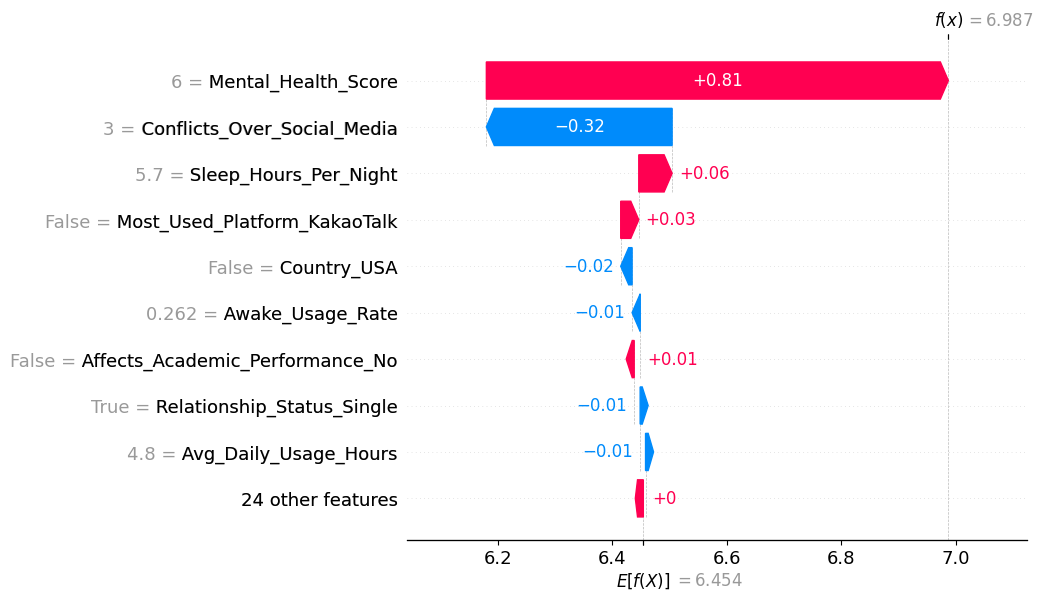

In [47]:
shap.plots.waterfall(shap_values[1])

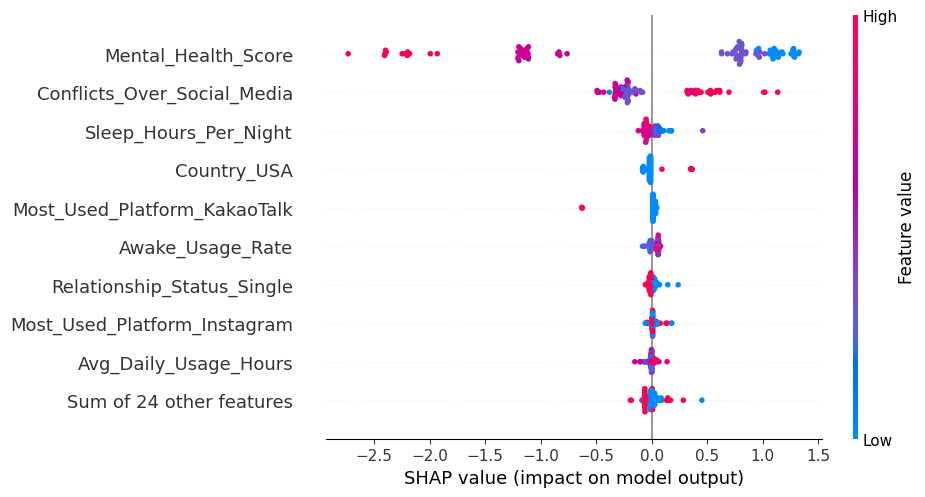

In [48]:
shap.plots.beeswarm(shap_values)

## 9. Sonuç ve Öneriler

Bu çalışmada, öğrencilerin sosyal medya bağımlılık skorlarını tahmin etmek amacıyla kapsamlı bir veri bilimi projesi yürütülmüştür. SHAP (Açıklanabilir Yapay Zeka) analizimiz, modelin kararlarının psikoloji literatürüyle birebir örtüştüğünü kanıtlamıştır.

### 1. Teknik Bulgular
* **Model Performansı:** Geliştirilen **XGBoost Regresyon** modeli, test verisi üzerinde **0.98 R2 Skoru** gçok yüksek bir açıklayıcılık oranına ulaşmıştır.
* **Model Karşılaştırması:** Yapılan **A/B Testi (Wilcoxon Signed-Rank)** sonucunda, XGBoost modelinin Lineer Regresyon'a göre istatistiksel olarak anlamlı derecede daha başarılı olduğu kanıtlanmıştır (p < 0.05).

### 2. Kritik Belirleyiciler (SHAP Analizi)
Modelin karar mekanizmasını incelediğimizde, bağımlılığı artıran en önemli 3 faktör şunl1.  **Mental Sağlık Skoru (Mental Health Score):** En güçlü belirleyicidir. Depresyon ve kaygı düzeyi yüksek olan öğrencilerde bağımlılık riski zirve yapmaktadır.
2.  **Sosyal Çatışmalar (Conflicts Over Social Media):** *Dikkat Çekici Bulgu* Sadece kullanım süresi değil, sosyal medya yüzünden yaşanan tartışmalar, bağımlılığın en net ikinci göstergesidir.
3.  **Uyku Süresi (Sleep Hours Per Night):** Geceleri az uyku uyuan kişiler net bir şekilde sosyal medya bağımlılığına eğilim göstermektedirndırılmalıdır.

## 10. Model Kayıt (Serialization)

In [49]:
final_model = xgb_model  

model_filename = 'social_media_addiction_model.pkl'
columns_filename = 'model_columns.pkl'

joblib.dump(final_model, model_filename)

joblib.dump(X_train.columns, columns_filename)

['model_columns.pkl']

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              705 non-null    int64  
 1   Avg_Daily_Usage_Hours            705 non-null    float64
 2   Sleep_Hours_Per_Night            705 non-null    float64
 3   Mental_Health_Score              705 non-null    int64  
 4   Conflicts_Over_Social_Media      705 non-null    int64  
 5   Addicted_Score                   705 non-null    int64  
 6   Awake_Usage_Rate                 705 non-null    float64
 7   Conflict_Per_Hour                705 non-null    float64
 8   Gender_Female                    705 non-null    bool   
 9   Academic_Level_encoded           705 non-null    int64  
 10  Affects_Academic_Performance_No  705 non-null    bool   
 11  Relationship_Status_Single       705 non-null    bool   
 12  Most_Used_Platform_Fac

In [51]:
print(df['Academic_Level_encoded'].unique())

[1 2 0]


In [52]:
# Örnek: Akademik seviye dağılımını gör
print(df['Academic_Level_encoded'].value_counts())

Academic_Level_encoded
1    353
2    325
0     27
Name: count, dtype: int64


In [53]:
# Örnek: Akademik seviye dağılımını gör
print(df['Conflict_Per_Hour'].value_counts())

Conflict_Per_Hour
0.636943    17
0.443459    16
0.453515    15
0.623701    15
0.650759    15
            ..
0.453858     1
0.505689     1
0.447094     1
0.499376     1
0.745156     1
Name: count, Length: 145, dtype: int64


In [54]:
# Örnek: Akademik seviye dağılımını gör
print(df['Awake_Usage_Rate'].value_counts())

Awake_Usage_Rate
0.265060    11
0.279762     8
0.350282     8
0.260606     8
0.269461     7
            ..
0.286624     1
0.317708     1
0.297468     1
0.289308     1
0.368715     1
Name: count, Length: 398, dtype: int64


In [55]:
# Örnek: Akademik seviye dağılımını gör
print(df['Addicted_Score'].value_counts())

Addicted_Score
7    209
8    144
5    136
4     83
6     61
9     55
3     16
2      1
Name: count, dtype: int64


In [58]:
# Örnek: Akademik seviye dağılımını gör
print(df['Conflicts_Over_Social_Media'].value_counts())

Conflicts_Over_Social_Media
3    261
2    204
4    174
1     47
5     15
0      4
Name: count, dtype: int64


In [59]:
# Örnek: Akademik seviye dağılımını gör
print(df['Mental_Health_Score'].value_counts())

Mental_Health_Score
6    219
7    178
5    173
8    105
4     29
9      1
Name: count, dtype: int64


In [60]:
# Örnek: Akademik seviye dağılımını gör
print(df['Sleep_Hours_Per_Night'].value_counts())

Sleep_Hours_Per_Night
7.3    28
7.2    28
7.4    26
7.5    25
6.7    25
6.8    24
5.8    23
6.5    23
5.9    21
6.2    20
7.8    20
7.1    20
6.6    20
7.9    19
6.3    19
8.0    18
6.0    18
5.7    18
7.0    18
6.4    17
8.1    16
7.6    16
8.2    15
5.5    15
7.7    15
8.3    15
6.9    14
5.4    14
8.4    14
5.2    13
6.1    12
5.3    11
8.5    10
8.6     9
5.6     9
5.0     7
8.7     7
5.1     7
8.8     6
8.9     5
4.9     5
4.8     4
9.0     3
9.1     3
9.2     3
4.6     3
4.7     3
4.5     3
9.4     2
9.3     2
9.5     2
4.2     2
4.1     2
4.3     2
4.4     2
4.0     1
3.9     1
9.6     1
3.8     1
Name: count, dtype: int64


In [61]:
# Örnek: Akademik seviye dağılımını gör
print(df['Avg_Daily_Usage_Hours'].value_counts())

Avg_Daily_Usage_Hours
4.7    31
4.5    30
4.8    29
4.6    28
4.4    27
       ..
7.7     1
7.6     1
1.5     1
2.1     1
8.5     1
Name: count, Length: 67, dtype: int64
